# Quy trình dự kiến
1. Phân tích dữ liệu
   * Xem file rain và era5 dạng tif
   * Dùng rasterio để chuyển các ảnh thành dataframe
   * Tạo các file csv thể hiện lượng mưa trong ngày dựa theo thời gian và kinh độ, vĩ độ
   * Tạo file csv tương tự với khí tượng
   * Thống kê giá trị null, 0 và các giá trị khác của các thể loại dữ liệu
   * Impute mưa = 0 (Số lượng null quá lớn trên 27% nên khó tìm cách, đang thử dùng kernel)
   * Rút ra các dữ liệu khí tượng có độ tương quan cao với lượng mưa
3. Feature Engineering
   * Rút ra các dữ liệu khí tượng có độ tương quan cao với lượng mưa
5. Xử lý dữ liệu
   * Chuẩn hóa dữ liệu: Min-Max Scaling hoặc Z-score Normalization.
   * Cắt & Resize ảnh: Đưa ảnh về kích thước 240x80
   * Chuẩn hóa ảnh khí tượng về kích thước phù hợp với ảnh mưa
   * Tạo tập train/test: Chia dữ liệu thành chuỗi thời gian hợp lý
   * Lưu dữ liệu: Xuất X và y để huấn luyện mô hình

In [1]:
!pip install rasterio
!pip install georasters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 70.7 MB/s eta 0:00:00:00:0100:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 67.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.6/141.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import numpy as np
from osgeo import gdal
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import pandas as pd
import georasters as gr
import pandas as pd
import rasterio
from matplotlib.table import Table

In [3]:
RADAR_DIR = "/kaggle/input/radar1/Radar"
ERA5_DIR = "/kaggle/input/era005/ERA5"

# RAIN

<Axes: >

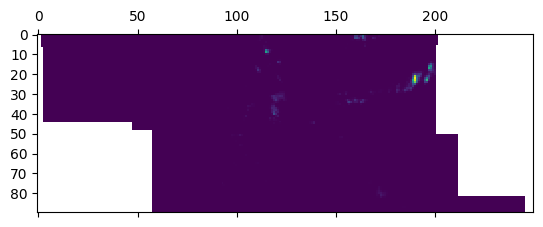

In [4]:
radar = gr.from_file('/kaggle/input/radar1/Radar/2019/04/01/Radar_20190401000000.tif')
radar.plot()

<Axes: >

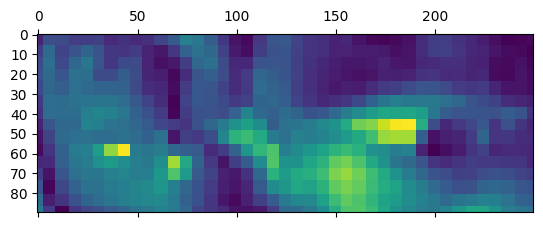

In [5]:
era = gr.from_file('/kaggle/input/era005/ERA5/CAPE/2019/04/01/CAPE_20190401000000.tif')
era.plot()

**In thử dữ liệu ra để xem, kiểm tra band, in value theo tọa độ, đếm giá trị = 0, = -inf**

In [6]:
# Đường dẫn file radar TIFF
file_path = '/kaggle/input/radar1/Radar/2019/04/01/Radar_20190401000000.tif'

# Mở file TIFF
with rasterio.open(file_path) as src:
    # Kiểm tra số band
    num_bands = src.count
    print(f"Số band trong file: {num_bands}")
    
    # Lấy thông tin transform và CRS
    transform = src.transform
    crs = src.crs
    print("CRS:", crs)
    
    # Tạo lưới tọa độ
    rows, cols = src.shape  # Kích thước của band
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    lon, lat = rasterio.transform.xy(transform, y, x)
    
    # Lưu dữ liệu từng band
    band_data = {}
    for band_idx in range(1, num_bands + 1):
        # Đọc dữ liệu của band hiện tại
        data = src.read(band_idx)
        df = pd.DataFrame({
            'longitude': np.array(lon).ravel(),
            'latitude': np.array(lat).ravel(),
            f'value_band_{band_idx}': data.ravel()
        })
        band_data[f'Band {band_idx}'] = df
    
    # In bảng dữ liệu cho từng band
    for band_name, df in band_data.items():
        print(f"\nBảng dữ liệu cho {band_name}:")
        print(df.head())  # In 5 dòng đầu tiên
        col = f'value_band_{band_name.split()[1]}'
        num_inf = (df[col] == -np.inf).sum()
        num_zero = (df[col] == 0.0).sum()
        num_other = len(df[col]) - num_inf - num_zero
            
        print(f"Số giá trị -inf trong {band_name}: {num_inf}")
        print(f"Số giá trị 0 trong {band_name}: {num_zero}")
        print(f"Số giá trị khác (-inf và 0) trong {band_name}: {num_other}")
        print(f"Tổng số giá trị trong {band_name}: {len(df[col])}")


# Kiểm tra thêm thông tin file
with rasterio.open(file_path) as src:
    print("\nThông tin file TIFF:")
    print(f"Kích thước: {src.width} x {src.height}")
    print(f"Data type: {src.dtypes}")

Số band trong file: 1
CRS: EPSG:4326

Bảng dữ liệu cho Band 1:
   longitude  latitude  value_band_1
0     101.02     21.08          -inf
1     101.06     21.08          -inf
2     101.10     21.08           0.0
3     101.14     21.08           0.0
4     101.18     21.08           0.0
Số giá trị -inf trong Band 1: 6401
Số giá trị 0 trong Band 1: 15284
Số giá trị khác (-inf và 0) trong Band 1: 815
Tổng số giá trị trong Band 1: 22500

Thông tin file TIFF:
Kích thước: 250 x 90
Data type: ('float32',)


In [7]:
# Hàm đọc file TIFF và chuyển thành DataFrame
def tiff_to_df(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Đọc band đầu tiên
        transform = src.transform
        rows, cols = data.shape
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        lon, lat = rasterio.transform.xy(transform, y, x)
        
        # Tạo DataFrame
        df = pd.DataFrame({
            'longitude': np.array(lon).ravel(),
            'latitude': np.array(lat).ravel(),
            'value': data.ravel()
        })
        return df

In [8]:
# Hàm lấy ngày từ tên file
def get_date_from_filename(filename):
    # Ví dụ: Radar_20190401000000.tif -> 20190401
    date_str = filename.split('_')[1][:8]  # Lấy YYYYMMDD
    return date_str

# Duyệt qua các năm, tháng, ngày
years = ['2019', '2020']
months = ['04', '10']

**Gộp file tif theo ngày **

In [9]:
for year in years:
    for month in months:
        month_dir = os.path.join(RADAR_DIR, year, month)
        if not os.path.exists(month_dir):
            continue
        
        # Lấy danh sách các ngày trong tháng
        days = sorted(os.listdir(month_dir))
        
        for day in days:
            day_dir = os.path.join(month_dir, day)
            if not os.path.isdir(day_dir):
                continue
            
            # Lấy danh sách file TIFF trong ngày
            tiff_files = sorted([f for f in os.listdir(day_dir) if f.endswith('.tif')])
            if not tiff_files:
                continue
            
            # Đọc file đầu tiên để lấy lưới tọa độ chuẩn
            first_file = os.path.join(day_dir, tiff_files[0])
            base_df = tiff_to_df(first_file)
            date = get_date_from_filename(tiff_files[0])
            
            # Khởi tạo DataFrame gộp với cột longitude, latitude
            merged_df = base_df[['longitude', 'latitude']].copy()
            
            # Gộp giá trị từ các file trong ngày
            for tiff_file in tiff_files:
                file_path = os.path.join(day_dir, tiff_file)
                df = tiff_to_df(file_path)
                
                # Lấy thời gian từ tên file làm tên cột (HHMMSS)
                time_str = tiff_file.split('_')[1][8:14]  # Lấy HHMMSS
                merged_df[f'value_{time_str}'] = df['value']
            
            # Lưu bảng gộp thành CSV
            output_file = f'Radar_{date}.csv'
            merged_df.to_csv(output_file, index=False)
            print(f"Đã xử lý và lưu bảng cho ngày {date} vào {output_file}")

Đã xử lý và lưu bảng cho ngày 20190401 vào Radar_20190401.csv
Đã xử lý và lưu bảng cho ngày 20190402 vào Radar_20190402.csv
Đã xử lý và lưu bảng cho ngày 20190403 vào Radar_20190403.csv
Đã xử lý và lưu bảng cho ngày 20190404 vào Radar_20190404.csv
Đã xử lý và lưu bảng cho ngày 20190405 vào Radar_20190405.csv
Đã xử lý và lưu bảng cho ngày 20190406 vào Radar_20190406.csv
Đã xử lý và lưu bảng cho ngày 20190407 vào Radar_20190407.csv
Đã xử lý và lưu bảng cho ngày 20190408 vào Radar_20190408.csv
Đã xử lý và lưu bảng cho ngày 20190409 vào Radar_20190409.csv
Đã xử lý và lưu bảng cho ngày 20190410 vào Radar_20190410.csv
Đã xử lý và lưu bảng cho ngày 20190411 vào Radar_20190411.csv
Đã xử lý và lưu bảng cho ngày 20190412 vào Radar_20190412.csv
Đã xử lý và lưu bảng cho ngày 20190413 vào Radar_20190413.csv
Đã xử lý và lưu bảng cho ngày 20190414 vào Radar_20190414.csv
Đã xử lý và lưu bảng cho ngày 20190415 vào Radar_20190415.csv
Đã xử lý và lưu bảng cho ngày 20190416 vào Radar_20190416.csv
Đã xử lý

File /kaggle/input/radar1/Radar/2019/10/08/Radar_20191008000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/10/Radar_20191010000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/17/Radar_20191017000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/18/Radar_20191018000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/19/Radar_20191019000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/20/Radar_20191020000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/27/Radar_20191027000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2019/10/30/Radar_20191030000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2020/10/26/Radar_20201026000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2020/10/28/Radar_20201028000000.tif không tồn tại
File /kaggle/input/radar1/Radar/2020/10/29/Radar_20201029000000.tif không tồn tại

Bảng tổng hợp số lượng các loại giá trị theo file:
              File  -inf      0  Other
0   Rad

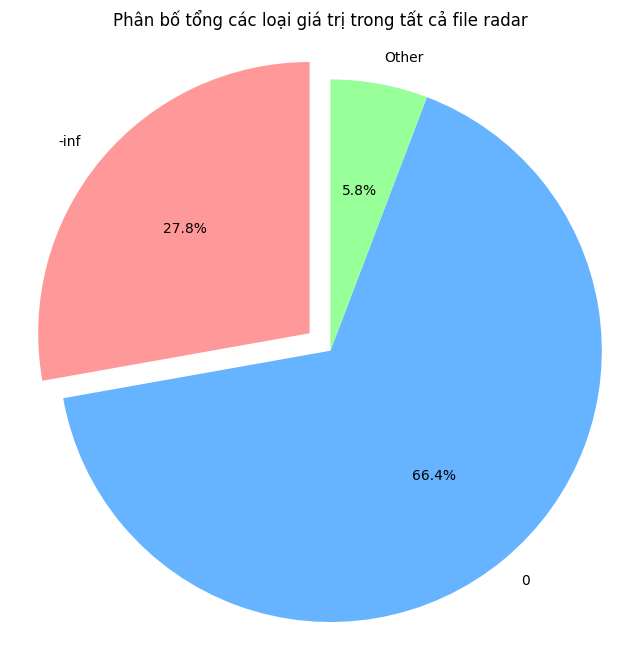

In [10]:
# Danh sách file radar (được cung cấp trước đó)
file_list = [
    "Radar_20190401", "Radar_20190402", "Radar_20190403", "Radar_20190404",
    "Radar_20190405", "Radar_20190406", "Radar_20190407", "Radar_20190408",
    "Radar_20190409", "Radar_20190410", "Radar_20190411", "Radar_20190412",
    "Radar_20190413", "Radar_20190414", "Radar_20190415", "Radar_20190416",
    "Radar_20190417", "Radar_20190418", "Radar_20190419", "Radar_20190420",
    "Radar_20190421", "Radar_20190422", "Radar_20190423", "Radar_20190424",
    "Radar_20190425", "Radar_20190426", "Radar_20190427", "Radar_20190428",
    "Radar_20190429", "Radar_20190430", "Radar_20191001", "Radar_20191002",
    "Radar_20191003", "Radar_20191004", "Radar_20191008", "Radar_20191010",
    "Radar_20191011", "Radar_20191012", "Radar_20191013", "Radar_20191014",
    "Radar_20191015", "Radar_20191016", "Radar_20191017", "Radar_20191018",
    "Radar_20191019", "Radar_20191020", "Radar_20191022", "Radar_20191023",
    "Radar_20191024", "Radar_20191025", "Radar_20191026", "Radar_20191027",
    "Radar_20191028", "Radar_20191029", "Radar_20191030", "Radar_20191031",
    "Radar_20200401", "Radar_20200402", "Radar_20200403", "Radar_20200404",
    "Radar_20200405", "Radar_20200406", "Radar_20200407", "Radar_20200408",
    "Radar_20200409", "Radar_20200410", "Radar_20200411", "Radar_20200412",
    "Radar_20200413", "Radar_20200414", "Radar_20200415", "Radar_20200416",
    "Radar_20200417", "Radar_20200418", "Radar_20200419", "Radar_20200420",
    "Radar_20200421", "Radar_20200422", "Radar_20200423", "Radar_20201001",
    "Radar_20201002", "Radar_20201003", "Radar_20201004", "Radar_20201005",
    "Radar_20201006", "Radar_20201007", "Radar_20201008", "Radar_20201009",
    "Radar_20201010", "Radar_20201011", "Radar_20201012", "Radar_20201013",
    "Radar_20201014", "Radar_20201015", "Radar_20201016", "Radar_20201017",
    "Radar_20201018", "Radar_20201019", "Radar_20201020", "Radar_20201021",
    "Radar_20201022", "Radar_20201023", "Radar_20201024", "Radar_20201025",
    "Radar_20201026", "Radar_20201027", "Radar_20201028", "Radar_20201029",
    "Radar_20201030", "Radar_20201031"# Loại bỏ phần đuôi .csv để linh hoạt
]

# Hàm đọc dữ liệu từ file TIFF
def read_radar_tiff(file_path):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)  # Đọc band 1 (giả định 1 band)
            return data.ravel()
    return None

# Hàm đọc dữ liệu từ file CSV (nếu vẫn dùng CSV)
def read_radar_csv(file_path):
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        value_cols = [col for col in df.columns if col.startswith('value_')]
        return df[value_cols].values.ravel()
    return None

# Tạo bảng tổng hợp và dữ liệu cho biểu đồ tròn
summary_data = {'File': [], '-inf': [], '0': [], 'Other': []}
total_inf = 0
total_zero = 0
total_other = 0

for file_name in file_list:
    # Điều chỉnh đường dẫn cho TIFF
    date = file_name.split('_')[1]
    year, month, day = date[:4], date[4:6], date[6:8]
    file_path = os.path.join(RADAR_DIR, year, month, day, f"{file_name}000000.tif")
    
    # Nếu dùng CSV, uncomment dòng sau và comment dòng TIFF
    # file_path = os.path.join(csv_dir, f"{file_name}.csv")
    
    data = read_radar_tiff(file_path)  # Dùng TIFF
    # data = read_radar_csv(file_path)  # Dùng CSV
    
    if data is not None:
        num_inf = np.sum(data == -np.inf)
        num_zero = np.sum(data == 0.0)
        num_other = len(data) - num_inf - num_zero
        
        summary_data['File'].append(file_name)
        summary_data['-inf'].append(num_inf)
        summary_data['0'].append(num_zero)
        summary_data['Other'].append(num_other)
        
        total_inf += num_inf
        total_zero += num_zero
        total_other += num_other
    else:
        print(f"File {file_path} không tồn tại")

# Tạo DataFrame tổng hợp
summary_df = pd.DataFrame(summary_data)
print("\nBảng tổng hợp số lượng các loại giá trị theo file:")
print(summary_df)

# Vẽ biểu đồ tròn
labels = ['-inf', '0', 'Other']
sizes = [total_inf, total_zero, total_other]
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.1, 0, 0)  # Tách phần -inf ra một chút

plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title("Phân bố tổng các loại giá trị trong tất cả file radar")
plt.axis('equal')  # Đảm bảo biểu đồ tròn
plt.show()

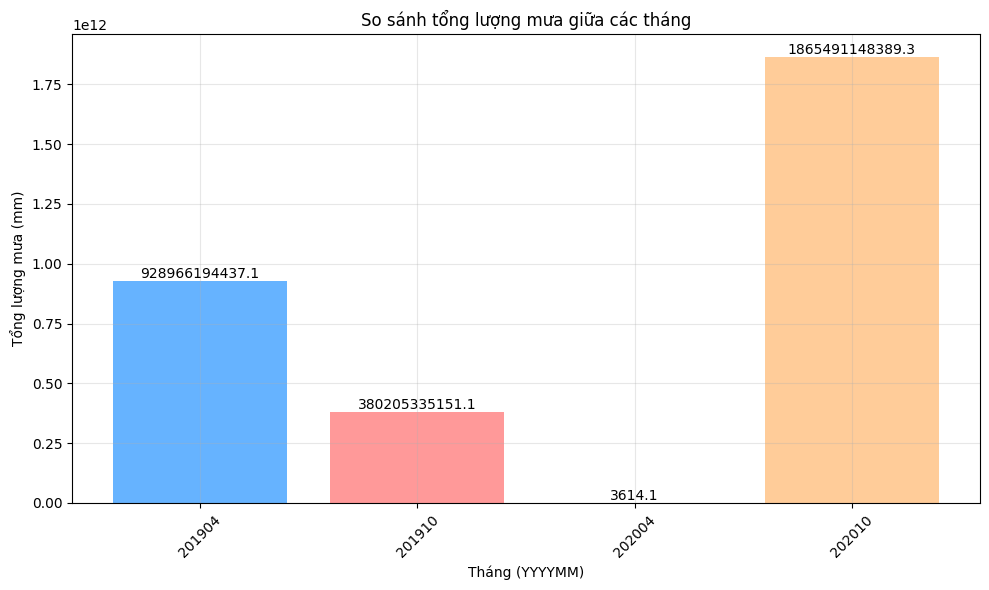


Số ngày có dữ liệu trong mỗi tháng:
201904: 30 ngày
201910: 26 ngày
202004: 23 ngày
202010: 31 ngày


In [11]:
from collections import defaultdict
# Hàm chuyển dBZ sang lượng mưa (mm/h)
def dBZ_to_rainfall(dBZ, a=200, b=1.6):
    # Vector hóa: xử lý mảng thay vì từng giá trị
    dBZ = np.where(np.isinf(dBZ) | np.isnan(dBZ), 0, dBZ)  # Thay -inf và NaN bằng 0
    Z = 10 ** (dBZ / 10)
    R = (Z / a) ** (1 / b)
    return R

# Tính tổng lượng mưa cho mỗi tháng
monthly_rainfall = defaultdict(float)
monthly_days = defaultdict(int)
csv_dir = "/kaggle/working/"
for file_name in file_list:
    file_path = os.path.join(csv_dir, f"{file_name}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        value_cols = [col for col in df.columns if col.startswith('value_')]
        
        # Vector hóa thay vì applymap
        rainfall_values = dBZ_to_rainfall(df[value_cols].values)
        rainfall = rainfall_values.mean() * len(value_cols)  # Tổng mưa trong ngày (trung bình x số giờ)
        
        month_key = file_name[6:12]  # Lấy YYYYMM (ví dụ: 201904)
        monthly_rainfall[month_key] += rainfall
        monthly_days[month_key] += 1
    else:
        print(f"File {file_path} không tồn tại")

# Tạo danh sách tháng và tổng lượng mưa
months = list(monthly_rainfall.keys())
rainfall_totals = [monthly_rainfall[month] for month in months]

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(months, rainfall_totals, color=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.xlabel("Tháng (YYYYMM)")
plt.ylabel("Tổng lượng mưa (mm)")
plt.title("So sánh tổng lượng mưa giữa các tháng")
plt.xticks(rotation=45)

# Thêm giá trị lên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}", ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In số ngày của mỗi tháng
print("\nSố ngày có dữ liệu trong mỗi tháng:")
for month in months:
    print(f"{month}: {monthly_days[month]} ngày")

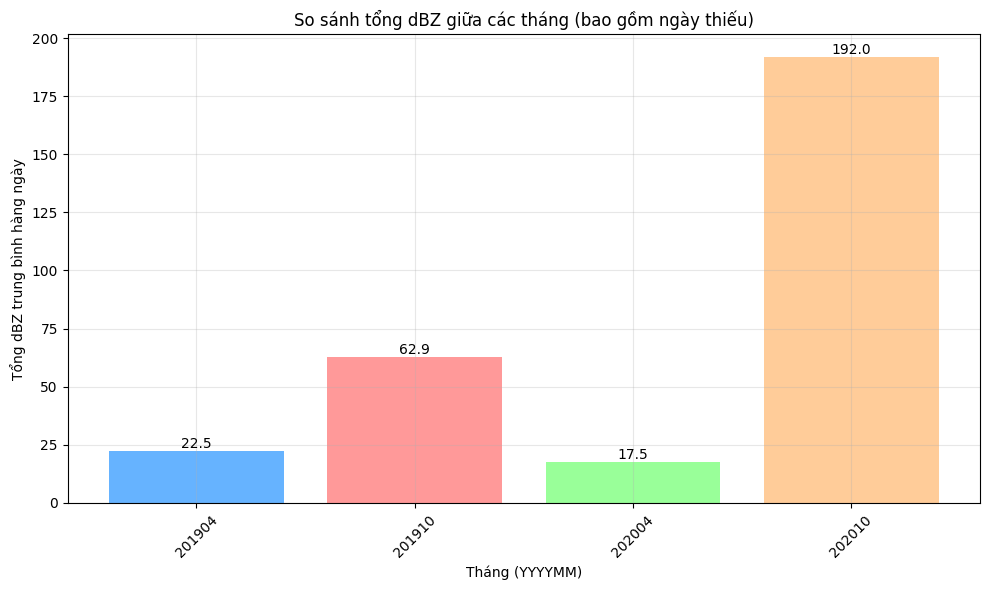


Số ngày có dữ liệu và tổng ngày trong mỗi tháng:
201904: 720/30 ngày có dữ liệu
201910: 497/31 ngày có dữ liệu
202004: 546/30 ngày có dữ liệu
202010: 724/31 ngày có dữ liệu


In [12]:
def read_radar_tiff(file_path):
    if os.path.exists(file_path):
        with rasterio.open(file_path) as src:
            data = src.read(1)
            return data.ravel()
    return None

# Tự động quét tất cả file TIFF trong thư mục
def get_all_tiff_files(base_dir):
    file_list = []
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.tif') and file.startswith('Radar_'):
                file_list.append(os.path.join(root, file))
    return file_list

# Danh sách các tháng cần phân tích
months_to_analyze = ['201904', '201910', '202004', '202010']

# Tính tổng dBZ và số ngày có dữ liệu
monthly_dbz = defaultdict(float)
monthly_days_with_data = defaultdict(int)
tiff_files = get_all_tiff_files(RADAR_DIR)

# Xử lý dữ liệu từ các file TIFF
for file_path in tiff_files:
    file_name = os.path.basename(file_path)
    date = file_name[6:14]  # YYYYMMDD
    year, month = date[:4], date[4:6]
    month_key = f"{year}{month}"
    
    if month_key in months_to_analyze:
        data = read_radar_tiff(file_path)
        if data is not None:
            # Giữ nguyên dBZ, thay -inf và NaN bằng 0
            dbz_values = np.where(np.isinf(data) | np.isnan(data), 0, data)
            dbz_mean = dbz_values.mean()  # Trung bình dBZ hàng ngày
            monthly_dbz[month_key] += dbz_mean
            monthly_days_with_data[month_key] += 1
        else:
            print(f"File {file_path} không tồn tại")

# Thêm thông tin cho các ngày thiếu
for month_key in months_to_analyze:
    year, month = month_key[:4], month_key[4:]
    days_in_month = pd.Timestamp(f"{year}-{month}-01").days_in_month  # Số ngày trong tháng
    
    # Số ngày có dữ liệu thực tế
    days_with_data = monthly_days_with_data[month_key]
    
    # Nếu thiếu ngày, thông báo nhưng không thay đổi tổng dBZ (ngầm hiểu dBZ = 0 cho ngày thiếu)
    if days_with_data < days_in_month:
        days_missing = days_in_month - days_with_data
        print(f"Tháng {month_key}: Có {days_with_data} ngày dữ liệu, thiếu {days_missing} ngày (dBZ = 0)")

# Tạo danh sách tháng và tổng dBZ
months = sorted(months_to_analyze)
dbz_totals = [monthly_dbz.get(month, 0) for month in months]  # Lấy tổng dBZ, mặc định 0 nếu không có dữ liệu

# Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
bars = plt.bar(months, dbz_totals, color=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.xlabel("Tháng (YYYYMM)")
plt.ylabel("Tổng dBZ trung bình hàng ngày")
plt.title("So sánh tổng dBZ giữa các tháng (bao gồm ngày thiếu)")
plt.xticks(rotation=45)

# Thêm giá trị lên đỉnh mỗi cột
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.1f}", ha='center', va='bottom')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# In số ngày có dữ liệu và tổng ngày trong tháng
print("\nSố ngày có dữ liệu và tổng ngày trong mỗi tháng:")
for month in months:
    days_in_month = pd.Timestamp(f"{month[:4]}-{month[4:]}-01").days_in_month
    days_with_data = monthly_days_with_data.get(month, 0)
    print(f"{month}: {days_with_data}/{days_in_month} ngày có dữ liệu")

In [13]:
# Hàm tính tần suất cho một file
def get_frequency(file_path):
    df = pd.read_csv(file_path)
    value_cols = [col for col in df.columns if col.startswith('value_')]
    freq_dict = {}
    for col in value_cols:
        freq_dict[col] = df[col].value_counts().sort_index()
    return freq_dict

#  Tính tần suất tổng hợp cho tất cả file
all_values = []
for file_name in file_list:
    file_path = os.path.join(csv_dir, f"{file_name}.csv")
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        value_cols = [col for col in df.columns if col.startswith('value_')]
        for col in value_cols:
            all_values.extend(df[col].dropna())
    else:
        print(f"File {file_name} không tồn tại.")
freq_all = pd.Series(all_values).value_counts().sort_index()

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1274: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1282: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1267: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py

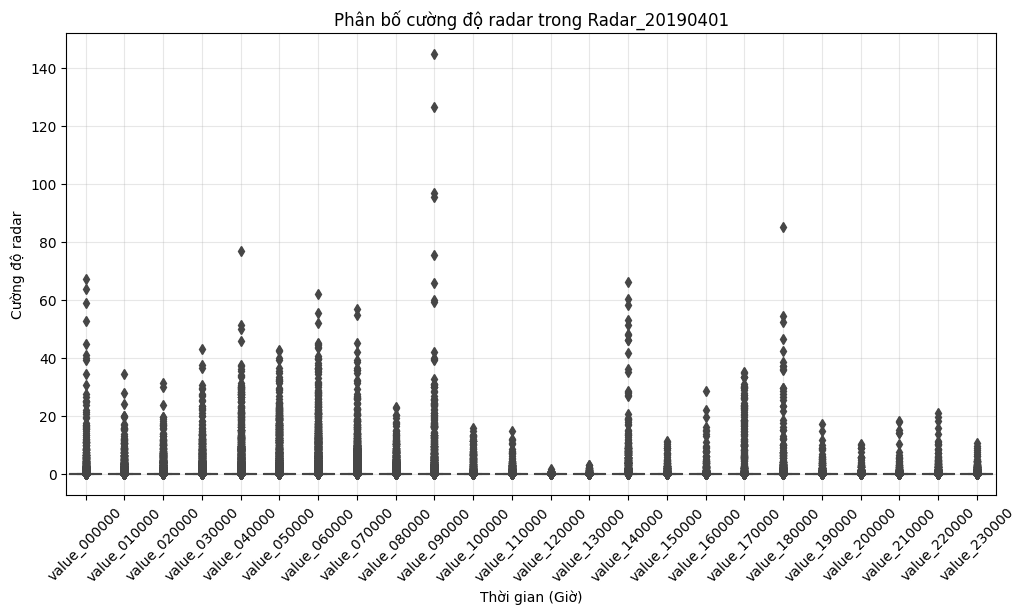

In [14]:
# Đọc file đầu tiên làm ví dụ
file_path = os.path.join(csv_dir, f"{file_list[0]}.csv")
df = pd.read_csv(file_path)
value_cols = [col for col in df.columns if col.startswith('value_')]

# Vẽ Box Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[value_cols])
plt.title(f"Phân bố cường độ radar trong {file_list[0]}")
plt.xlabel("Thời gian (Giờ)")
plt.ylabel("Cường độ radar")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

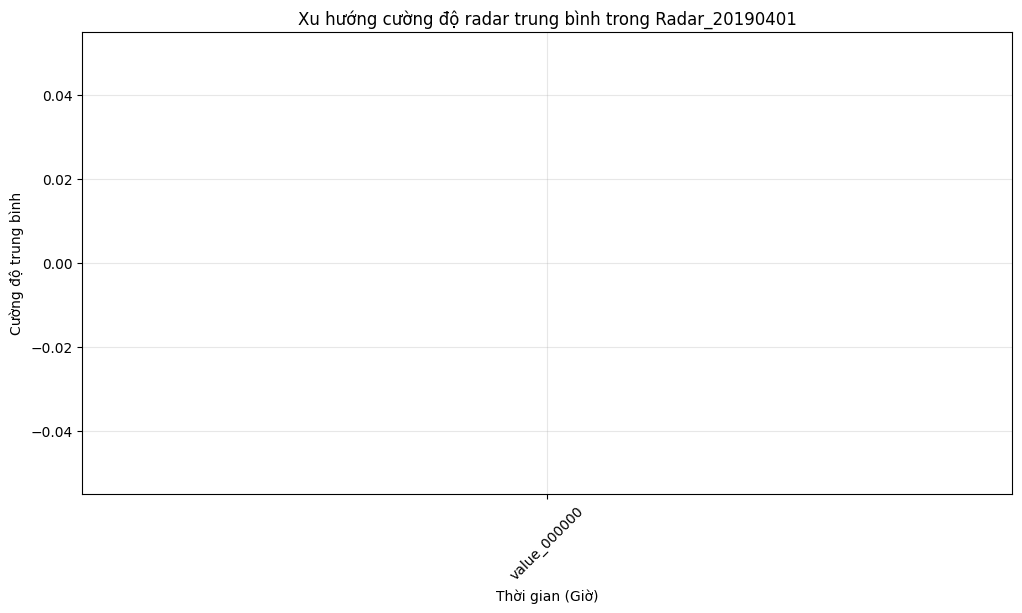

In [15]:
# Tính giá trị trung bình cho từng giờ
mean_values = df[value_cols].mean()

# Vẽ Line Plot
plt.figure(figsize=(12, 6))
plt.plot(mean_values.index, mean_values.values, marker='o')
plt.title(f"Xu hướng cường độ radar trung bình trong {file_list[0]}")
plt.xlabel("Thời gian (Giờ)")
plt.ylabel("Cường độ trung bình")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

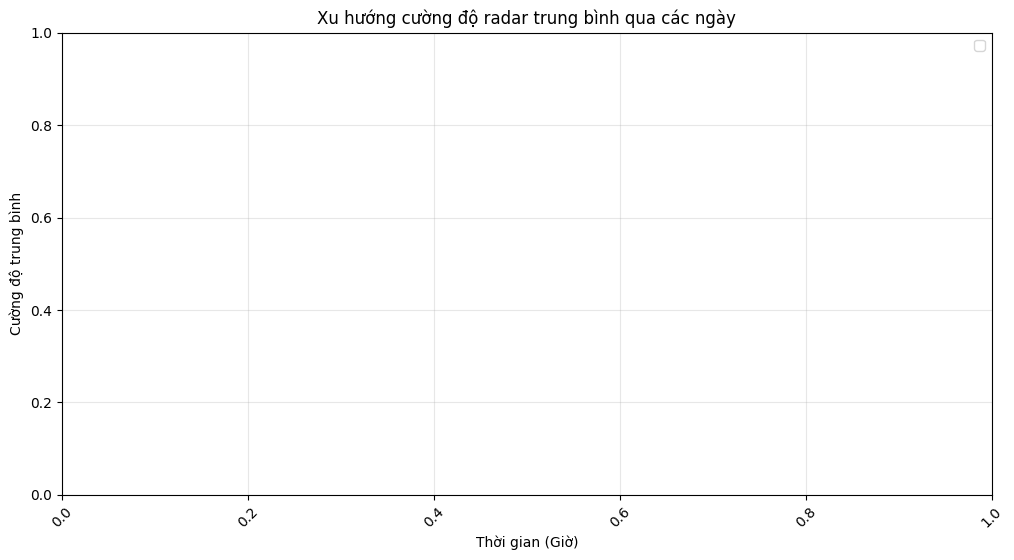

In [16]:
# Tính trung bình cho tất cả file
mean_dict = {}
for file_name in file_list:
    file_path = os.path.join(csv_dir, file_name)
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        value_cols = [col for col in df.columns if col.startswith('value_')]
        mean_dict[file_name] = df[value_cols].mean()

# Chuyển thành DataFrame
mean_df = pd.DataFrame(mean_dict)

# Vẽ Line Plot cho nhiều ngày
plt.figure(figsize=(12, 6))
for column in mean_df.columns:
    plt.plot(mean_df.index, mean_df[column], marker='o', label=column)
plt.title("Xu hướng cường độ radar trung bình qua các ngày")
plt.xlabel("Thời gian (Giờ)")
plt.ylabel("Cường độ trung bình")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ERA5


1. CAPE (Convective Available Potential Energy) – Năng lượng khả dụng đối lưu, biểu thị tiềm năng của không khí để phát triển đối lưu mạnh (bão, dông).
2. CIN (Convective Inhibition) – Chỉ số ức chế đối lưu, mô tả mức độ ngăn cản không khí đi lên, ảnh hưởng đến khả năng hình thành bão dông.
3. EWSS (East-West Shear Stress) – Lực cắt gió theo hướng Đông-Tây.
4. IE (Ice Equivalent) – Khối lượng nước tương đương băng (thường dùng để đo lượng băng hoặc tuyết trong khí quyển).
5. ISOR (Isotropic Wind Speed or Vorticity) – Có thể là tốc độ gió đẳng hướng hoặc xoáy thuận.
6. KX (K-Index) – Chỉ số K, một chỉ số đánh giá tiềm năng đối lưu dựa trên nhiệt độ và độ ẩm của không khí.
7. PEV (Potential Evaporation) – Lượng bốc hơi tiềm năng của nước trên bề mặt.
8. R250, R500, R850 (Relative Humidity at 250 hPa, 500 hPa, 850 hPa) – Độ ẩm tương đối ở các tầng khí quyển 250 hPa, 500 hPa, 850 hPa.
9. SLHF (Surface Latent Heat Flux) – Dòng nhiệt ẩn từ bề mặt (liên quan đến sự bốc hơi và ngưng tụ).
10. SLOR (Surface Orographic Lift) – Nâng địa hình bề mặt, ảnh hưởng đến sự phát triển của mây khi không khí bị đẩy lên bởi địa hình.
11. SSHF (Surface Sensible Heat Flux) – Dòng nhiệt cảm từ bề mặt (liên quan đến sự trao đổi nhiệt giữa mặt đất và khí quyển).
12. TCLW (Total Cloud Liquid Water) – Tổng lượng nước lỏng trong mây.
13. TCW (Total Column Water) – Tổng lượng nước trong toàn bộ cột khí quyển.
14. TCWV (Total Column Water Vapor) – Tổng lượng hơi nước trong toàn bộ cột khí quyển.
15. U250, U850 (U-Component of Wind at 250 hPa, 850 hPa) – Thành phần gió hướng Tây-Đông ở độ cao 250 hPa và 850 hPa.
16. V250, V850 (V-Component of Wind at 250 hPa, 850 hPa) – Thành phần gió hướng Bắc-Nam ở độ cao 250 hPa và 850 hPa.1. 

In [17]:
# Danh sách các biến ERA5
ERA5_VARIABLES = [
    "CAPE", "CIN", "EWSS", "IE", "ISOR", "KX", "PEV", "R250", "R500", "R850",
    "SLHF", "SLOR", "SSHF", "TCLW", "TCW", "TCWV", "U250", "U850", "V250", "V850"
]

In [18]:
def tiff_to_df(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1)  # Đọc band đầu tiên
        transform = src.transform
        rows, cols = data.shape
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        lon, lat = rasterio.transform.xy(transform, y, x)
        return pd.DataFrame({
            'longitude': np.array(lon).ravel(),
            'latitude': np.array(lat).ravel(),
            'value': data.ravel()
        })

# Xử lý dữ liệu ERA5 cho một ngày mẫu (ví dụ: 20190401)
date = "20190401"
era5_data = {}
for var in ERA5_VARIABLES:
    era5_data[var] = {}
    for hour in range(24):
        time_str = f"{hour:02d}0000"
        file_path = os.path.join(ERA5_DIR, var, date[:4], date[4:6], date[6:8], f"{var}_{date}{time_str}.tif")
        if os.path.exists(file_path):
            df = tiff_to_df(file_path)
            era5_data[var][time_str] = df
        else:
            print(f"File {file_path} không tồn tại.")

In [19]:
# Gộp dữ liệu ERA5 cho ngày 20190401
merged_era5_df = None
for var in ERA5_VARIABLES:
    for time_str, df in era5_data[var].items():
        col_name = f"{var}_{time_str}"
        if merged_era5_df is None:
            merged_era5_df = df.rename(columns={'value': col_name})
        else:
            merged_era5_df = merged_era5_df.merge(
                df[['longitude', 'latitude', 'value']].rename(columns={'value': col_name}),
                on=['longitude', 'latitude'],
                how='outer'
            )

print("Dữ liệu ERA5 gộp cho ngày 20190401:")
print(merged_era5_df.head())

Dữ liệu ERA5 gộp cho ngày 20190401:
   longitude  latitude  CAPE_000000  CAPE_010000  CAPE_020000  CAPE_030000  \
0     101.02     17.52      895.000      818.875       962.00       1329.5   
1     101.02     17.56      895.000      818.875       962.00       1329.5   
2     101.02     17.60      895.000      818.875       962.00       1329.5   
3     101.02     17.64      778.125      690.625       581.75        844.0   
4     101.02     17.68      778.125      690.625       581.75        844.0   

   CAPE_040000  CAPE_050000  CAPE_060000  CAPE_070000  ...  V850_140000  \
0        986.5      846.875     1138.625       889.75  ...     3.316650   
1        986.5      846.875     1138.625       889.75  ...     3.316650   
2        986.5      846.875     1138.625       889.75  ...     3.316650   
3        751.0      746.875      801.000       868.50  ...     3.459229   
4        751.0      746.875      801.000       868.50  ...     3.459229   

   V850_150000  V850_160000  V850_170000  V8

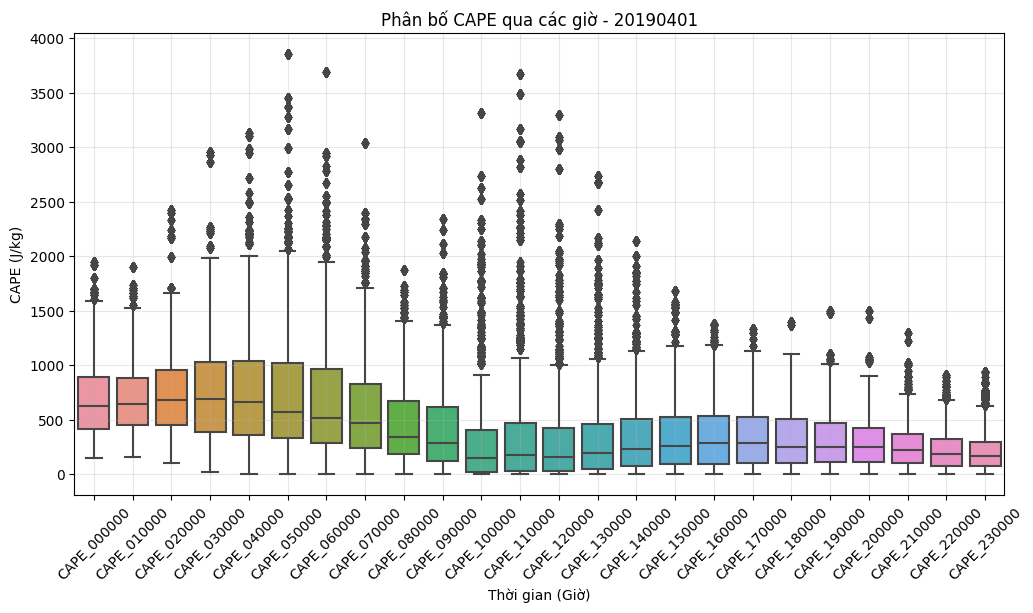

In [20]:
cape_cols = [col for col in merged_era5_df.columns if col.startswith('CAPE_')]

# Vẽ Box Plot cho CAPE
plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_era5_df[cape_cols].dropna(how='all'))
plt.title("Phân bố CAPE qua các giờ - 20190401")
plt.xlabel("Thời gian (Giờ)")
plt.ylabel("CAPE (J/kg)")
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

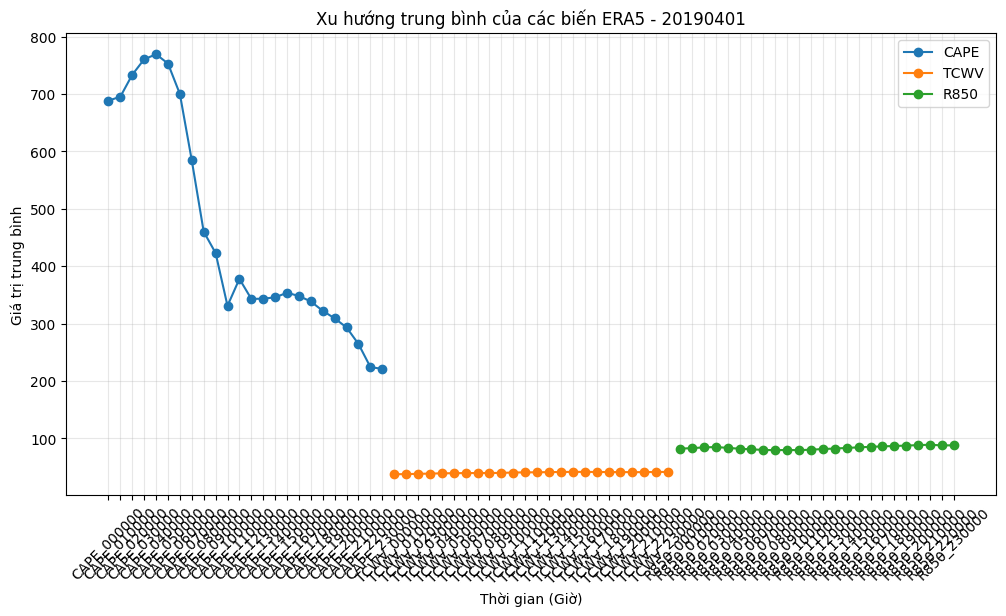

In [21]:
# Tính trung bình cho từng biến qua các giờ
mean_values = {}
for var in ERA5_VARIABLES:
    var_cols = [col for col in merged_era5_df.columns if col.startswith(f"{var}_")]
    mean_values[var] = merged_era5_df[var_cols].mean(skipna=True)

# Vẽ Line Plot cho một số biến chính
plt.figure(figsize=(12, 6))
for var in ['CAPE', 'TCWV', 'R850']:  # Ví dụ: CAPE, TCWV, R850
    plt.plot(mean_values[var].index, mean_values[var].values, marker='o', label=var)
plt.title("Xu hướng trung bình của các biến ERA5 - 20190401")
plt.xlabel("Thời gian (Giờ)")
plt.ylabel("Giá trị trung bình")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

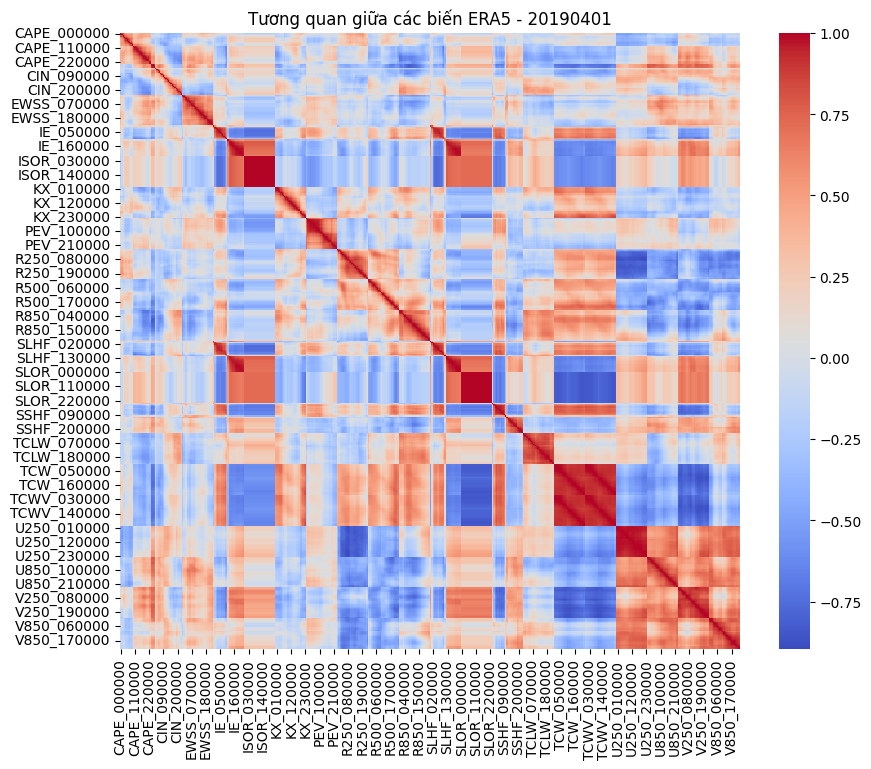

Tương quan với CAPE:
CAPE_190000    0.708873
CAPE_180000    0.708164
CAPE_210000    0.701304
CAPE_200000    0.699821
CAPE_110000    0.683541
dtype: float64


In [22]:
# Tính tương quan giữa các biến
corr_matrix = merged_era5_df[[col for col in merged_era5_df.columns if col not in ['longitude', 'latitude']]].corr()

# Vẽ heatmap tương quan
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Tương quan giữa các biến ERA5 - 20190401")
plt.show()

# In các biến có tương quan cao với CAPE
print("Tương quan với CAPE:")
print(corr_matrix[[col for col in corr_matrix.columns if 'CAPE' in col]].loc[[col for col in corr_matrix.index if 'CAPE' not in col]].abs().max().sort_values(ascending=False).head())

In [23]:
merged_era5_df.to_csv(f"ERA5_{date}.csv", index=False)

# Xử lý dữ liệu

In [24]:
import os
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Thư mục chứa dữ liệu
RADAR_DIR = '/kaggle/working'  # Đường dẫn radar
ERA5_DIR = '/kaggle/input/era005/ERA5'  # Giả định đường dẫn ERA5, thay bằng đường dẫn thực tế

# Danh sách biến ERA5 có thể chọn
ERA5_VARIABLES = [
    "CAPE", "CIN", "EWSS", "IE", "ISOR", "KX", "PEV", "R250", "R500", "R850",
    "SLHF", "SLOR", "SSHF", "TCLW", "TCW", "TCWV", "U250", "U850", "V250", "V850"
]
# Hàm 1: Đọc và xử lý dữ liệu radar cho một ngày
def get_rainfall_data(date):
    radar_file = os.path.join(RADAR_DIR, f"Radar_{date}.csv")
    if os.path.exists(radar_file):
        radar_df = pd.read_csv(radar_file)
        value_cols = [col for col in radar_df.columns if col.startswith('value_')]
        rainfall_means = radar_df[value_cols].mean().apply(dBZ_to_rainfall)
        rainfall_normalized = (rainfall_means - rainfall_means.min()) / (rainfall_means.max() - rainfall_means.min())
        return rainfall_normalized
    else:
        print(f"File {radar_file} không tồn tại.")
        return None

# Hàm chuyển dBZ sang lượng mưa (mm/h)
def dBZ_to_rainfall(dBZ, a=200, b=1.6):
    if pd.isna(dBZ):
        return np.nan
    Z = 10 ** (dBZ / 10)
    R = (Z / a) ** (1 / b)
    return R

# Hàm 2: Đọc và xử lý dữ liệu ERA5 cho một ngày
def get_era5_data(date, variables):
    era5_data = {}
    for var in variables:
        hourly_means = []
        for hour in range(24):
            time_str = f"{hour:02d}0000"
            file_path = os.path.join(ERA5_DIR, var, date[:4], date[4:6], date[6:8], f"{var}_{date}{time_str}.tif")
            if os.path.exists(file_path):
                with rasterio.open(file_path) as src:
                    data = src.read(1)
                    mean_value = pd.Series(data.ravel()).mean()
                    hourly_means.append(mean_value)
            else:
                hourly_means.append(np.nan)
        era5_series = pd.Series(hourly_means, index=[f"{h:02d}0000" for h in range(24)])
        era5_normalized = (era5_series - era5_series.min()) / (era5_series.max() - era5_series.min())
        era5_data[var] = era5_normalized
    return era5_data

# Hàm 3: Vẽ đồ thị và bảng cho một tháng
def plot_monthly_data_with_table(year, month, variables=ERA5_VARIABLES[:3], days=None):
    """
    Vẽ đồ thị Line Plot và bảng số liệu cho các ngày trong một tháng.
    
    Parameters:
    - year (str): Năm (ví dụ: '2019')
    - month (str): Tháng (ví dụ: '04')
    - variables (list): Danh sách biến ERA5 muốn vẽ (mặc định: ['CAPE', 'TCWV', 'R850'])
    - days (list): Danh sách ngày cụ thể (mặc định: tất cả ngày trong tháng)
    """
    # Tạo danh sách ngày trong tháng
    if days is None:
        days = [f"{year}{month}{d:02d}" for d in range(1, 32) if os.path.exists(os.path.join(RADAR_DIR, f"Radar_{year}{month}{d:02d}.csv"))]
    else:
        days = [f"{year}{month}{d:02d}" for d in days]

    # Tạo lưới subplot
    n_days = len(days)
    n_cols = 2  # Số cột (mỗi ngày: đồ thị + bảng)
    n_rows = n_days  # Mỗi ngày một hàng
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows), gridspec_kw={'width_ratios': [2, 1]})

    # Vẽ từng ngày
    colors = ['red', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow']  # Màu cho các biến
    for idx, date in enumerate(days):
        ax_plot = axes[idx, 0]  # Cột 0: Đồ thị
        ax_table = axes[idx, 1]  # Cột 1: Bảng
        
        # 1. Vẽ đồ thị
        rainfall_data = get_rainfall_data(date)
        if rainfall_data is not None:
            ax_plot.plot(rainfall_data.index, rainfall_data.values, marker='o', label='Lượng mưa', color='blue', linewidth=2)
            table_data = {'Hour': [h.split('_')[1] for h in rainfall_data.index], 'Rain': rainfall_data.values.round(2)}
        else:
            table_data = {'Hour': [f"{h:02d}0000" for h in range(24)], 'Rain': [np.nan] * 24}

        era5_data = get_era5_data(date, variables)
        for i, var in enumerate(variables):
            if var in era5_data:
                ax_plot.plot(era5_data[var].index, era5_data[var].values, marker='o', label=var, color=colors[i % len(colors)])
                table_data[var] = era5_data[var].values.round(2)

        ax_plot.set_title(f"Ngày {date[6:8]}/{month}/{year}")
        ax_plot.set_xlabel("Thời gian (Giờ)")
        ax_plot.set_ylabel("Giá trị chuẩn hóa (0-1)")
        ax_plot.tick_params(axis='x', rotation=45)
        ax_plot.grid(True, alpha=0.3)
        ax_plot.legend(loc='upper left')

        # 2. Vẽ bảng số liệu
        ax_table.axis('off')  # Tắt trục cho bảng
        table_df = pd.DataFrame(table_data)
        table = Table(ax_table, bbox=[0, 0, 1, 1])
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        
        # Thêm tiêu đề cột
        for col_idx, col in enumerate(table_df.columns):
            table.add_cell(0, col_idx, width=0.1, height=0.05, text=col, loc='center', facecolor='lightgray')
        
        # Thêm dữ liệu
        for row_idx, row in table_df.iterrows():
            for col_idx, val in enumerate(row):
                table.add_cell(row_idx + 1, col_idx, width=0.1, height=0.05, text=str(val), loc='center')
        
        ax_table.add_table(table)

    plt.suptitle(f"Biểu đồ và số liệu lượng mưa + ERA5 - Tháng {month}/{year}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:

# Ví dụ sử dụng hàm
# Vẽ cho tháng 04/2019 với tất cả các ngày
plot_monthly_data_with_table('2019', '04', ERA5_VARIABLES)


In [ ]:

# Vẽ cho tháng 10/2019 với 3 ngày cụ thể
plot_monthly_data_with_table('2019', '10', variables=['CAPE', 'TCWV'], days=[1, 2, 3])